In [1]:
import os
path = os.getcwd()
path

'/home/dyna/Documents/sawada/debate_score'

In [2]:
# roberta_linear_test
## import module

import random
import numpy as np
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
import set_debates


Using TensorFlow backend.


In [3]:
# cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
## speech, score set

microchip_debate = "./topic/microchip/debates.txt"
microchip_order = "./topic/microchip/orders.txt"
microchip_score = "./topic/microchip/scores.txt"
part_job_debate = "./topic/part-time-job/debates.txt"
part_job_order = "./topic/part-time-job/orders.txt"
part_job_score = "./topic/part-time-job/scores.txt"
four_work_debate = "./topic/four-day-work/debates.txt"
four_work_order = "./topic/four-day-work/orders.txt"
four_work_score = "./topic/four-day-work/scores.txt"

# speech
Mdebate_lists = set_debates.set_speech_list(microchip_debate,microchip_order)
Mspeeches_list = set_debates.flatten(Mdebate_lists)
# score
with open(microchip_score, 'r') as h:
    scores = h.read()
    Mscore_list = [float(s) for s in scores.split()]
    
# check    
len(Mspeeches_list) == len(Mscore_list)

True

In [6]:
## prepare inputs

##train
# tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
# token
speech_tokens = list(
    map(
        lambda t: tokenizer.tokenize(t)[:511], Mspeeches_list
    )
)
# encode   -ids
speech_ids = list(
    map(
        lambda t: tokenizer.encode(t, add_special_tokens=True), speech_tokens
    )
)
# 要素の大きさを512に　つめる
speech_ids = sequence.pad_sequences(
    speech_ids, maxlen=512, truncating='post', padding='post', dtype='int'
)

"""
##test
# token
test_speech_tokens = list(
    map(
        lambda t: tokenizer.tokenize(t)[:511], x_test
    )
)
# encode   -ids
test_speech_ids = list(
    map(
        lambda t: tokenizer.encode(t, add_special_tokens=True), test_speech_tokens
    )
)
# 512に
test_speech_ids = sequence.pad_sequences(
    test_speech_ids, maxlen=512, truncating='post', padding='post', dtype='int'
)
"""

"\n##test\n# token\ntest_speech_tokens = list(\n    map(\n        lambda t: tokenizer.tokenize(t)[:511], x_test\n    )\n)\n# encode   -ids\ntest_speech_ids = list(\n    map(\n        lambda t: tokenizer.encode(t, add_special_tokens=True), test_speech_tokens\n    )\n)\n# 512に\ntest_speech_ids = sequence.pad_sequences(\n    test_speech_ids, maxlen=512, truncating='post', padding='post', dtype='int'\n)\n"

In [7]:
# 確認
len(speech_ids)

50

In [9]:
##train
# to_tensor
input_roberta = torch.tensor(speech_ids)
# input_size
input_roberta = input_roberta.to(device)
roberta = RobertaModel.from_pretrained("roberta-large")
roberta = roberta.to(device)
with torch.no_grad():
    roberta_out = roberta(input_roberta)
pooled_speech = roberta_out[1]

"""
## test
test_input_roberta = torch.tensor(test_speech_ids)
test_input_roberta = test_input_roberta.to(device)
with torch.no_grad():
    test_roberta_out = roberta(test_input_roberta)
test_pooled_speech = test_roberta_out[1]
test_pooled_speech.size()
"""

'\n## test\ntest_input_roberta = torch.tensor(test_speech_ids)\ntest_input_roberta = test_input_roberta.to(device)\nwith torch.no_grad():\n    test_roberta_out = roberta(test_input_roberta)\ntest_pooled_speech = test_roberta_out[1]\ntest_pooled_speech.size()\n'

In [119]:
"""
import pandas as pd

pd.set_option('display.max_columns', 200)
print(pd.get_option("display.max_columns"))
pd.set_option('display.max_rows', 200)
print(pd.get_option("display.max_rows"))

pooled_speech = pooled_speech.cpu().numpy()
tamtam = pd.DataFrame(pooled_speech)
## numpyになおしている注意
tamtam.to_csv("pooled_speech.csv")
"""

200
200


In [10]:
# label 確認
y_train = torch.tensor(Mscore_list, device=device)

y_train

tensor([ 28.5000,  24.2000,  27.1000,  20.0000,  14.2000,   8.5700, -25.7000,
         -5.7100, -20.0000, -15.7000,  26.6000, -20.0000,  -6.6600, -16.6000,
         13.3000, -10.0000, -30.0000, -10.0000, -26.6000, -40.0000, -23.3000,
         28.7000,  13.8000,  20.0000,  12.5000,  26.3000,  15.0000, -32.5000,
        -26.3000, -27.5000,  28.7000,   7.5000,  12.5000,  17.5000,  10.0000,
        -32.5000, -22.5000, -28.7500, -27.5000, -18.7500,  28.0000,  12.0000,
         16.0000,  16.0000,   2.0000, -26.0000, -18.0000, -22.0000, -22.0000,
        -18.0000], device='cuda:0')

In [11]:
# define_model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 1)

    def forward(self, x):
        out = self.fc1(x)
        return out

In [12]:
# hyper params
num_epochs = 500
learning_rate = 3e-4

model_cls = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cls.parameters(), lr=learning_rate)
model_cls = model_cls.to(device)

In [18]:

# set\data\logger
loss_log = []
loss_v_log = []


for epoch in range(num_epochs):
  # forward pass
    outputs = model_cls(pooled_speech)
    loss = criterion(outputs, y_train)

  # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if (epoch+1) % 10 == 0:
        print("Epoch:{}, Loss(train):{:.4f}".format(epoch+1, loss.item()))


# graph
    loss_log.append(loss.item())
#    loss_v_log.append(loss_val.item())
    
print('----DONE----')

Epoch:10, Loss(train):461.4875
Epoch:20, Loss(train):459.3588
Epoch:30, Loss(train):459.1491
Epoch:40, Loss(train):459.2196
Epoch:50, Loss(train):459.1504
Epoch:60, Loss(train):459.1212
Epoch:70, Loss(train):459.1251
Epoch:80, Loss(train):459.1219
Epoch:90, Loss(train):459.1206
Epoch:100, Loss(train):459.1208
Epoch:110, Loss(train):459.1205
Epoch:120, Loss(train):459.1205
Epoch:130, Loss(train):459.1205
Epoch:140, Loss(train):459.1204
Epoch:150, Loss(train):459.1204
Epoch:160, Loss(train):459.1204
Epoch:170, Loss(train):459.1204
Epoch:180, Loss(train):459.1203
Epoch:190, Loss(train):459.1202
Epoch:200, Loss(train):459.1202
Epoch:210, Loss(train):459.1202
Epoch:220, Loss(train):459.1202
Epoch:230, Loss(train):459.1201
Epoch:240, Loss(train):459.1201
Epoch:250, Loss(train):459.1201
Epoch:260, Loss(train):459.1201
Epoch:270, Loss(train):459.1201
Epoch:280, Loss(train):459.1200
Epoch:290, Loss(train):459.1200
Epoch:300, Loss(train):459.1200
Epoch:310, Loss(train):459.1200
Epoch:320, Loss(t

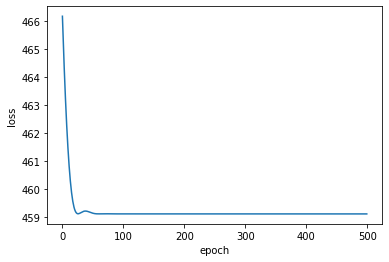

In [19]:
plt.plot(loss_log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#plt.plot(loss_v_log)

In [118]:
"""
# eval(teacher_data)

with torch.no_grad():
    preds = model_cls(test_pooled_speech)

print(preds, y_test)

"""

tensor([[21.2917],
        [21.2917],
        [21.2917],
        [21.2917],
        [23.1265],
        [22.5718],
        [22.8386],
        [23.1240],
        [22.8567],
        [22.6314]], device='cuda:0') tensor([ 29.,  15.,  25.,  14.,  18.,   8., -31., -20., -20., -24., -24.],
       device='cuda:0')
